# Exploration of Zipfness in Modern Tokenizers
Members: Jack Hanke, Daniel Plotkin, Nicole Birova

In [33]:
import numpy as np
import scipy.stats
from scipy.stats import zipf, ks_2samp, kstest, chisquare
import matplotlib.pyplot as plt
import json
from transformers import RobertaTokenizer, AutoTokenizer
import tiktoken
from tqdm import tqdm
from datasets import load_dataset, Dataset
import pickle



In [ ]:
# get RoBERTa, GPT-4 tokenizers


class RoBERTa_Tokenizer:
    def __init__(self):
        self.name = 'RoBERTa Tokenizer'
        self.tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")
    def tokenize(self, text_str: str):
        return self.tokenizer(text_str)['input_ids']
        return self.tokenizer.encode(text_str[:512])
        return self.tokenizer.encode(text_str)
    def detokenize(self, tokens: list[int]):
        return self.tokenizer.decode(tokens)

class GPT4_Tokenizer:
    def __init__(self):
        self.name = 'GPT 4 Tokenizer'
        self.tokenizer = tiktoken.encoding_for_model("gpt-4o")
    def tokenize(self, text_str: str):
        return self.tokenizer.encode(text_str, disallowed_special=())
    def detokenize(self, tokens: list[int]):
        return self.tokenizer.decode(tokens)

roberta_tokenizer = RoBERTa_Tokenizer()
gpt_tokenizer = GPT4_Tokenizer()

text_str = "Hello world"
assert roberta_tokenizer.detokenize(roberta_tokenizer.tokenize(text_str=text_str))
assert gpt_tokenizer.detokenize(gpt_tokenizer.tokenize(text_str=text_str))


In [2]:
print(roberta_tokenizer.tokenizer.vocab_size)
print(gpt_tokenizer.tokenizer.n_vocab)

50265
200019


In [4]:
# 
def increment_dict(dictionary: dict, key: str):
    try:
        dictionary[key] += 1
    except KeyError:
        dictionary[key] = 1

# 
def sort_dictionary(dictionary: dict):
    return {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

# 
# increment frequency for a given item (sentence) and a given tokenizer
def increment_frequency(dictionary:dict, item: str, tokenizer):
    # if no tokenizer, increment word freq
    if tokenizer is None:
        for count, word in enumerate(item.split()):
            increment_dict(dictionary=dictionary, key=word)
        return count+1
    
    # increment token freq
    tokens = tokenizer.tokenize(item)
    for count, token in enumerate(tokens):
        increment_dict(dictionary=dictionary, key=token)
    return count+1

# 
def normalize_dictionary(dictionary: dict, denominator: int):
    return_dictionary = {}
    for key, value in dictionary.items():
        return_dictionary[key] = value/denominator
    
    return return_dictionary


In [27]:
# get bookscorpus from: "https://storage.googleapis.com/huggingface-nlp/datasets/bookcorpus/bookcorpus.tar.bz2"


# experiment filenames
def experiment(filenames: list[str]):
    byte_freq_dict, word_freq_dict, gpt_token_freq_dict, roberta_token_freq_dict = {}, {}, {}, {}
    byte_count, word_count, gpt_token_count, roberta_token_count = 0, 0, 0, 0

    for filename in filenames:
        with open(filename, 'r') as f:
            prog_bar = tqdm(f.readlines())
            for line in prog_bar:
                item = str(line)
                # word_count += increment_frequency(dictionary=word_freq_dict, item=item, tokenizer=None)
                # gpt_token_count += increment_frequency(dictionary=gpt_token_freq_dict, item=item, tokenizer=gpt_tokenizer)
                # roberta_token_count += increment_frequency(dictionary=roberta_token_freq_dict, item=item, tokenizer=roberta_tokenizer)
            
                line_bytes = item.encode("utf-8") # raw bytes
                line_bytes_list = list(line_bytes) # list of integers in range 0..255
                for byte in line_bytes_list:
                    increment_dict(dictionary=byte_freq_dict, key=byte)
                    byte_count += 1

    # sort and normalize
    sorted_byte_freq_dict = sort_dictionary(dictionary=byte_freq_dict)
    byte_frequencies = normalize_dictionary(dictionary=sorted_byte_freq_dict, denominator=byte_count)

    sorted_word_freq_dict = sort_dictionary(dictionary=word_freq_dict)
    word_frequencies = normalize_dictionary(dictionary=sorted_word_freq_dict, denominator=word_count)

    sorted_gpt_token_freq_dict = sort_dictionary(dictionary=gpt_token_freq_dict)
    gpt_token_frequencies = normalize_dictionary(dictionary=sorted_gpt_token_freq_dict, denominator=gpt_token_count)

    sorted_roberta_token_freq_dict = sort_dictionary(dictionary=roberta_token_freq_dict)
    roberta_token_frequencies = normalize_dictionary(dictionary=sorted_roberta_token_freq_dict, denominator=roberta_token_count)

    return byte_frequencies, word_frequencies, gpt_token_frequencies, roberta_token_frequencies


In [28]:
# bookscorpus experiment
# NOTE these are over 2GB each
filenames = [f'data/books_large_p1.txt', f'data/books_large_p2.txt']

bookscorpus_byte_frequencies, bookscorpus_word_frequencies, bookscorpus_gpt_token_frequencies, bookscorpus_roberta_token_frequencies = experiment(filenames=filenames)

100%|██████████| 34004228/34004228 [02:35<00:00, 218386.41it/s]


In [29]:
import pickle
dataset = 'bookscorpus'
with open(f'distributions/{dataset}_bytes.pickle', 'wb') as f:
    pickle.dump(bookscorpus_byte_frequencies, f) 
# with open(f'distributions/{dataset}_words.pickle', 'wb') as f:
#     pickle.dump(bookscorpus_word_frequencies, f) 
# with open(f'distributions/{dataset}_gpt4.pickle', 'wb') as f:
#     pickle.dump(bookscorpus_gpt_token_frequencies, f) 
# with open(f'distributions/{dataset}_roberta.pickle', 'wb') as f:
#     pickle.dump(bookscorpus_roberta_token_frequencies, f) 

In [19]:

ds = load_dataset("JeanKaddour/minipile")

# def get_minipile():
#     ds.save_to_disk('data/minipile')

In [18]:
ds = load_dataset('data/minipile')

ValueError: Couldn't infer the same data file format for all splits. Got {NamedSplit('train'): ('arrow', {}), NamedSplit('validation'): ('json', {}), NamedSplit('test'): ('json', {})}

In [20]:

# experiment filenames
def minipile_experiment(ds: Dataset):
    byte_freq_dict, word_freq_dict, gpt_token_freq_dict, roberta_token_freq_dict = {}, {}, {}, {}
    byte_count, word_count, gpt_token_count, roberta_token_count = 0, 0, 0, 0

    prog_bar = tqdm(ds['train'])
    for line in prog_bar:
        item = str(line['text'])
        # word_count += increment_frequency(dictionary=word_freq_dict, item=item, tokenizer=None)
        # gpt_token_count += increment_frequency(dictionary=gpt_token_freq_dict, item=item, tokenizer=gpt_tokenizer)
        # roberta_token_count += increment_frequency(dictionary=roberta_token_freq_dict, item=item, tokenizer=roberta_tokenizer)

        line_bytes = item.encode("utf-8") # raw bytes
        line_bytes_list = list(line_bytes) # list of integers in range 0..255
        for byte in line_bytes_list:
            increment_dict(dictionary=byte_freq_dict, key=byte)
            byte_count += 1

    # sort and normalize
    sorted_byte_freq_dict = sort_dictionary(dictionary=byte_freq_dict)
    byte_frequencies = normalize_dictionary(dictionary=sorted_byte_freq_dict, denominator=byte_count)

    sorted_word_freq_dict = sort_dictionary(dictionary=word_freq_dict)
    word_frequencies = normalize_dictionary(dictionary=sorted_word_freq_dict, denominator=word_count)

    sorted_gpt_token_freq_dict = sort_dictionary(dictionary=gpt_token_freq_dict)
    gpt_token_frequencies = normalize_dictionary(dictionary=sorted_gpt_token_freq_dict, denominator=gpt_token_count)

    sorted_roberta_token_freq_dict = sort_dictionary(dictionary=roberta_token_freq_dict)
    roberta_token_frequencies = normalize_dictionary(dictionary=sorted_roberta_token_freq_dict, denominator=roberta_token_count)

    return byte_frequencies, word_frequencies, gpt_token_frequencies, roberta_token_frequencies

minipile_byte_frequencies, minipile_word_frequencies, minipile_gpt_token_frequencies, minipile_roberta_token_frequencies = minipile_experiment(ds = ds)

100%|██████████| 1000000/1000000 [07:25<00:00, 2245.90it/s]


In [ ]:
# save distributions


dataset = 'minipile'
with open(f'{dataset}_bytes.pickle', 'wb') as f:
    pickle.dump(minipile_byte_frequencies, f) 
# with open(f'{dataset}_words.pickle', 'wb') as f:
#     pickle.dump(minipile_word_frequencies, f) 
# with open(f'{dataset}_gpt4.pickle', 'wb') as f:
#     pickle.dump(minipile_gpt_token_frequencies, f) 
# with open(f'{dataset}_roberta.pickle', 'wb') as f:
#     pickle.dump(minipile_roberta_token_frequencies, f) 

In [30]:
# load distributions
import pickle

# dataset = 'minipile'
# with open(f'distributions/{dataset}_bytes.pickle', 'rb') as f:
#     minipile_byte_frequencies = pickle.load(f) 
# with open(f'distributions/{dataset}_words.pickle', 'rb') as f:
#     minipile_word_frequencies = pickle.load(f) 
# with open(f'distributions/{dataset}_gpt4.pickle', 'rb') as f:
#     minipile_gpt_token_frequencies = pickle.load(f) 
# with open(f'distributions/{dataset}_roberta.pickle', 'rb') as f:
#     minipile_roberta_token_frequencies = pickle.load(f) 
    
dataset = 'bookscorpus'
with open(f'distributions/{dataset}_bytes.pickle', 'rb') as f:
    bookscorpus_byte_frequencies = pickle.load(f) 
with open(f'distributions/{dataset}_words.pickle', 'rb') as f:
    bookscorpus_word_frequencies = pickle.load(f) 
with open(f'distributions/{dataset}_gpt4.pickle', 'rb') as f:
    bookscorpus_gpt_token_frequencies = pickle.load(f) 
with open(f'distributions/{dataset}_roberta.pickle', 'rb') as f:
    bookscorpus_roberta_token_frequencies = pickle.load(f) 

In [26]:
# NOTE most common tokens and words!
lim = 100
bookscorpus_word_len = len(bookscorpus_word_frequencies)
bookscorpus_roberta_len = len(bookscorpus_roberta_token_frequencies)
bookscorpus_gpt_len = len(bookscorpus_gpt_token_frequencies)
minipile_word_len = len(minipile_word_frequencies)
minipile_roberta_len = len(minipile_roberta_token_frequencies)
minipile_gpt_len = len(minipile_gpt_token_frequencies)

# print(bookscorpus_word_len)
# print(bookscorpus_roberta_len)
# print(bookscorpus_gpt_len)
# print(minipile_word_len)
# print(minipile_roberta_len)
# print(minipile_gpt_len)

# for i, (key, value) in enumerate(bookscorpus_word_frequencies.items()):
#     # print(key, value)
#     # if i == lim: break
#     if i >= bookscorpus_word_len - lim:
#         print(key, value)
# print('-----------------')
# for i, (key, value) in enumerate(minipile_word_frequencies.items()):
#     # print(key, value)
#     # if i == lim: break
#     if i >= minipile_word_len - lim:
#         print(key, value)

for i, (key, value) in enumerate(bookscorpus_roberta_token_frequencies.items()):
    # if i == lim: break
    if i >= bookscorpus_roberta_len - lim:
        print(roberta_tokenizer.detokenize(key), value)
# print('-----------------')
# for i, (key, value) in enumerate(minipile_roberta_token_frequencies.items()):
#     # if i == lim: break
#     if i >= minipile_roberta_len - lim:
#         print(roberta_tokenizer.detokenize(key), value)

# for i, (key, value) in enumerate(bookscorpus_gpt_token_frequencies.items()):
#     # if i == lim: break
#     if i >= bookscorpus_gpt_len - lim:
#         print(gpt_tokenizer.detokenize([key]), value)
# print('-----------------')
# for i, (key, value) in enumerate(minipile_gpt_token_frequencies.items()):
#     # if i == lim: break
#     if i >= minipile_gpt_len - lim:
#         print(gpt_tokenizer.detokenize([key]), value)

803 1.5310877515400526e-09
linux 1.5310877515400526e-09
ablished 1.5310877515400526e-09
ntax 1.5310877515400526e-09
200000 1.5310877515400526e-09
''. 1.5310877515400526e-09
agonists 1.5310877515400526e-09
 livestream 1.5310877515400526e-09
/. 1.5310877515400526e-09
vertising 1.5310877515400526e-09
enfranch 1.5310877515400526e-09
inances 1.5310877515400526e-09
 conflic 1.5310877515400526e-09
969 1.5310877515400526e-09
ettings 1.5310877515400526e-09
 rgb 1.5310877515400526e-09
-, 1.5310877515400526e-09
func 1.5310877515400526e-09
cfg 1.5310877515400526e-09
ternity 1.5310877515400526e-09
 github 1.5310877515400526e-09
953 1.5310877515400526e-09
 /// 1.5310877515400526e-09
initialized 1.5310877515400526e-09
 args 1.5310877515400526e-09
=/ 1.5310877515400526e-09
antage 1.5310877515400526e-09
 volunte 1.5310877515400526e-09
055 1.5310877515400526e-09
++++++++++++++++ 1.5310877515400526e-09
++++++++ 1.5310877515400526e-09
 subparagraph 1.5310877515400526e-09
offset 1.5310877515400526e-09
ipha

In [18]:
# print(f'books word: {sum([float(value) for key, value in bookscorpus_word_frequencies.items()])}')
# print(f'books rob tok: {sum([float(value) for key, value in bookscorpus_roberta_token_frequencies.items()])}')
# print(f'books gpt tok: {sum([float(value) for key, value in bookscorpus_gpt_token_frequencies.items()])}')

# print(f'minipile word: {sum([float(value) for key, value in minipile_word_frequencies.items()])}')
# print(f'minipile rob tok: {sum([float(value) for key, value in minipile_roberta_token_frequencies.items()])}')
# print(f'minipile gpt tok: {sum([float(value) for key, value in minipile_gpt_token_frequencies.items()])}')

# books_words = [round(1/float(value)) for key, value in bookscorpus_word_frequencies.items()][-1]
# books_words_list = []
# books_words_dict = {}
# for key_num, (key, value) in enumerate(bookscorpus_word_frequencies.items()):
#     # books_words_list += [key_num for _ in range(round(float(value)*books_words))]
#     books_words_dict[key]= round(float(value)*books_words)

# books_rob_token = [round(1/float(value)) for key, value in bookscorpus_roberta_token_frequencies.items()][-1]
# books_rob_token_list = []
# books_rob_token_dict = {}
# for key_num, (key, value) in enumerate(bookscorpus_roberta_token_frequencies.items()):
#     # books_rob_token_list += [key_num for _ in range(round(float(value)*books_rob_token))]
#     books_rob_token_dict[key]= round(float(value)*books_rob_token)

# books_gpt_token = [round(1/float(value)) for key, value in bookscorpus_gpt_token_frequencies.items()][-1]
# books_gpt_token_list = []
# books_gpt_token_dict = {}
# for key_num, (key, value) in enumerate(bookscorpus_gpt_token_frequencies.items()):
#     # books_gpt_token_list += [key_num for _ in range(round(float(value)*books_gpt_token))]
#     books_gpt_token_dict[key]= round(float(value)*books_gpt_token)

# mini_words = [round(1/float(value)) for key, value in minipile_word_frequencies.items()][-1]
# mini_words_list = []
# mini_words_dict = {}
# for key_num, (key, value) in enumerate(minipile_word_frequencies.items()):
#     # mini_words_list += [key_num for _ in range(round(float(value)*mini_words))]
#     mini_words_dict[key]= round(float(value)*mini_words)

# mini_rob_token = [round(1/float(value)) for key, value in minipile_roberta_token_frequencies.items()][-1]
# mini_rob_token_list = []
# mini_rob_token_dict = {}
# for key_num, (key, value) in enumerate(minipile_roberta_token_frequencies.items()):
#     # mini_rob_token_list += [key_num for _ in range(round(float(value)*mini_rob_token))]
#     mini_rob_token_dict[key]= round(float(value)*mini_rob_token)

mini_gpt_token = [round(1/float(value)) for key, value in minipile_gpt_token_frequencies.items()][-1]
mini_gpt_token_list = []
mini_gpt_token_dict = {}
for key_num, (key, value) in enumerate(minipile_gpt_token_frequencies.items()):
    # mini_gpt_token_list += [key_num for _ in range(round(float(value)*mini_gpt_token))]
    mini_gpt_token_dict[key]= round(float(value)*mini_gpt_token)



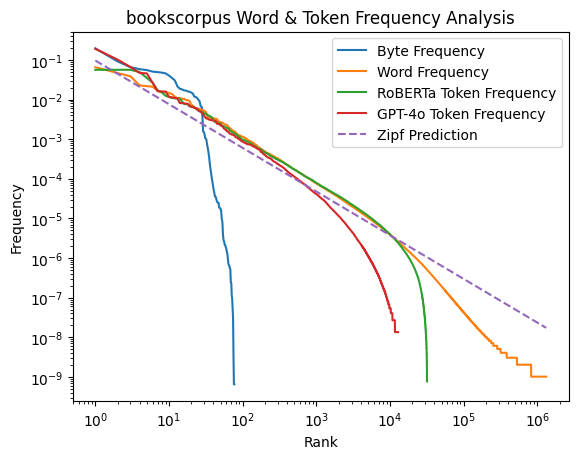

In [31]:
# 
import matplotlib.pyplot as plt
from math import log

alpha = 1.103

# bookscorpus
plt.plot([key_num+1 for key_num, key in enumerate(bookscorpus_byte_frequencies)], [float(value) for key, value in bookscorpus_byte_frequencies.items()], label='Byte Frequency')
plt.plot([key_num+1 for key_num, key in enumerate(bookscorpus_word_frequencies)], [float(value) for key, value in bookscorpus_word_frequencies.items()], label='Word Frequency')
plt.plot([key_num+1 for key_num, key in enumerate(bookscorpus_roberta_token_frequencies)], [float(value) for key, value in bookscorpus_roberta_token_frequencies.items()], label='RoBERTa Token Frequency')
plt.plot([key_num+1 for key_num, key in enumerate(bookscorpus_gpt_token_frequencies)], [float(value) for key, value in bookscorpus_gpt_token_frequencies.items()], label='GPT-4o Token Frequency')
plt.plot([key_num+1 for key_num, key in enumerate(bookscorpus_word_frequencies)], [zipf.pmf(key_num+1, alpha) for key_num, key in enumerate(bookscorpus_word_frequencies)], label='Zipf Prediction', linestyle='dashed')
plt.title(f'bookscorpus Word & Token Frequency Analysis')

# minipile
# plt.plot([key_num+1 for key_num, key in enumerate(minipile_byte_frequencies)], [float(value) for key, value in minipile_byte_frequencies.items()], label='Byte Frequency')
# plt.plot([key_num+1 for key_num, key in enumerate(minipile_word_frequencies)], [float(value) for key, value in minipile_word_frequencies.items()], label='Word Frequency')
# plt.plot([key_num+1 for key_num, key in enumerate(minipile_roberta_token_frequencies)], [float(value) for key, value in minipile_roberta_token_frequencies.items()], label='RoBERTa Token Frequency')
# plt.plot([key_num+1 for key_num, key in enumerate(minipile_gpt_token_frequencies)], [float(value) for key, value in minipile_gpt_token_frequencies.items()], label='GPT-4o Token Frequency')
# plt.plot([key_num+1 for key_num, key in enumerate(minipile_word_frequencies)], [zipf.pmf(key_num+1, alpha) for key_num, key in enumerate(minipile_word_frequencies)], label='Zipf Prediction', linestyle='dashed')
# plt.title(f'MiniPile Word & Token Frequency Analysis')

plt.xlabel(f'Rank')
plt.ylabel(f'Frequency')
plt.yscale(f'log')
plt.xscale(f'log')
plt.legend()
plt.show()

In [ ]:


y = [float(val) for val in minipile_gpt_token_frequencies.values()]
# dist_names = ['zipf']
dist_names = ['expon', 'lognorm']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(books_words_list)
    print(f'dist {dist_name} params: {params}')

    info = scipy.stats.kstest(books_words_list, dist_name, args=params)
    print(f'dist {dist_name} has ks p_value: {info}')


'''
bookscorpus word:
    dist expon params: (1.0153874422544972e-09, 7.589230879387788e-07)
    dist expon has ks p_value: KstestResult(statistic=np.float64(0.874332786084574), pvalue=np.float64(0.0), statistic_location=np.float64(3.0461623267634917e-08), statistic_sign=np.int8(1))
    dist lognorm params: (np.float64(18.297301550856996), np.float64(1.015387442254497e-09), np.float64(3.16838237869172e-15))
    dist lognorm has ks p_value: KstestResult(statistic=np.float64(0.3790793182058966), pvalue=np.float64(0.0), statistic_location=np.float64(2.0307748845089944e-09), statistic_sign=np.int8(-1))
minipile word:
    dist expon params: (1.1531822317963101e-09, 2.97973577529876e-08)
    dist expon has ks p_value: KstestResult(statistic=np.float64(0.8084651820516531), pvalue=np.float64(0.0), statistic_location=np.float64(3.4595466953889304e-09), statistic_sign=np.int8(1))
    dist lognorm params: (np.float64(16.849736373495528), np.float64(1.15318223179631e-09), np.float64(8.498058092906186e-21))
    dist lognorm has ks p_value: KstestResult(statistic=np.float64(0.45099315157289), pvalue=np.float64(0.0), statistic_location=np.float64(1.1531822317963101e-09), statistic_sign=np.int8(1))
'''


dist expon params: (0.0, 3360.476778078534)


: 

In [ ]:
# TODO test if this works
# from scipy.stats import zipf, kstest
import scipy

for distribution in [
        bookscorpus_word_frequencies, 
        bookscorpus_roberta_token_frequencies, 
        bookscorpus_gpt_token_frequencies, 
        minipile_word_frequencies, 
        minipile_roberta_token_frequencies, 
        minipile_gpt_token_frequencies
    ]:
    y = [float(val) for val in distribution.values()]
    alpha = 1.1
    # alpha = 5
    # TODO test Dan's zipf thing
    info = scipy.stats.kstest(y, scipy.stats.zipf(alpha).cdf)
    print(info)
    print(f'dist zipf has ks p_value: {info.statistic}')




KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.06594728307618831), statistic_sign=np.int8(1))
dist zipf has ks p_value: 1.0
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.056653483526488704), statistic_sign=np.int8(1))
dist zipf has ks p_value: 1.0
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.19177784004449044), statistic_sign=np.int8(1))
dist zipf has ks p_value: 1.0
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.047739417274623476), statistic_sign=np.int8(1))
dist zipf has ks p_value: 1.0
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.09183504867599476), statistic_sign=np.int8(1))
dist zipf has ks p_value: 1.0
KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(0.029901769192377796), statistic_sign=n

In [48]:
for dist_num, distribution in enumerate([
        # bookscorpus_word_frequencies, 
        # bookscorpus_roberta_token_frequencies, 
        # bookscorpus_gpt_token_frequencies, 
        minipile_word_frequencies, 
        # minipile_roberta_token_frequencies, 
        # minipile_gpt_token_frequencies
    ]):
    num_elements = round(1/list(distribution.values())[-1])
    # 
    f_obs = [round(float(val)*num_elements) for val in distribution.values()][:500000]
    num_elements_revised = sum(f_obs)

    alpha = 1.1
    zipf_dist = zipf(alpha)

    normalize = sum([zipf_dist.pmf(i) for i in range(1, len(f_obs)+1)])

    f_exp = [zipf_dist.pmf(i)*num_elements_revised/normalize for i in range(1, len(f_obs)+1)]

    info = chisquare(f_obs=f_obs, f_exp=f_exp)
    print(f'{dist_num} :: {info}')

0 :: Power_divergenceResult(statistic=np.float64(142938795.55655533), pvalue=np.float64(0.0))


In [ ]:


# Load precomputed frequency dictionaries
# with open('gpt_counts.json') as f:
#     gpt_counts = json.load(f)

# with open('rob_counts.json') as f:
#     rob_counts = json.load(f)

# with open('word_counts.json') as f:
#     word_counts = json.load(f)

def get_ranked_sample(freq_dict, max_rank=50000, sample_size=100000):
    items = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:max_rank]
    ranks = np.arange(1, len(items) + 1)
    freqs = np.array([count for _, count in items])
    probs = freqs / freqs.sum()
    sample = np.random.choice(ranks, size=sample_size, p=probs)
    return sample, ranks

def zipf_alpha_estimator(ranks):
    return 1 + len(ranks) / np.sum(np.log(ranks))

def ks_statistic_against_zipf(sample, alpha):
    ks_stat, _ = kstest(sample, zipf(alpha).cdf)
    return ks_stat

def run_zipf_test(freq_dict, label):
    sample, ranks = get_ranked_sample(freq_dict)
    alpha = zipf_alpha_estimator(ranks)
    ks_stat = ks_statistic_against_zipf(sample, alpha)
    print(f"zipf {label}: α={alpha:.3f}, KS={ks_stat:.4f}")

    dist_names = ['expon', 'lognorm']
    for dist_name in dist_names:
        dist = getattr(scipy.stats, dist_name)
        params = dist.fit(sample)
        # print(f'dist {dist_name} params: {params}')

        info = scipy.stats.kstest(sample, dist_name, args=params)
        print(f'{dist_name} {label} has KS={info.statistic:.4f}')

    return ks_stat


# Run tests
# print("Zipf KS Statistics:")
# word_ks = run_zipf_test(word_counts, "Words")
# rob_ks = run_zipf_test(rob_counts, "RoBERTa")
# gpt_ks = run_zipf_test(gpt_counts, "GPT-4o")

# word_ks = run_zipf_test(books_words_dict, "Words") # 0.3328
# rob_ks = run_zipf_test(books_rob_token_dict, "RoBERTa")
# rob_ks = run_zipf_test(books_gpt_token_dict, "RoBERTa")

# word_ks = run_zipf_test(books_words_dict, "Words") # 0.3328
# rob_ks = run_zipf_test(books_rob_token_dict, "RoBERTa")
# gpt_ks = run_zipf_test(books_gpt_token_dict, "GPT")
# rob_ks = run_zipf_test(mini_words_dict, "Words")
# rob_ks = run_zipf_test(mini_rob_token_dict, "RoBERTa")
rob_ks = run_zipf_test(mini_gpt_token_dict, "GPT")



zipf GPT: α=1.102, KS=0.3136
expon GPT has KS=0.4287
lognorm GPT has KS=0.2544
